<a href="https://colab.research.google.com/github/DavidUpegui/Workshop_ML/blob/main/Evaluaci%C3%B3n_inteligente_de_cr%C3%A9ditos_hipotecarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sé mi aprobación hipotecaria: Evaluación inteligente de créditos hipotecarios

##Inicialización

In [ ]:
#Importar e instalar librerías
import pandas as pd
import numpy as np

In [ ]:
#Para importar datos de Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importar la data
path = '/content/drive/MyDrive/Modelos II/Proyecto final/data/' #Change this path for your own path
raw_data = pd.read_csv(path + 'loan_sanction_train.csv')
raw_data.head(5)

Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0         Urban           Y  
3             1.0         Urban           Y  
4             1.0         Urban           Y

##Limpieza de datos


###Eliminación de columnas innecesarias

La columna ```Loan_id``` es una columna que no aporta información importante en la creación del modelo, por lo tanto esta es removida de la base de datos con la que trabajaremos

In [ ]:
raw_data = raw_data.drop('Loan_ID', axis=1)
raw_data.head(5)

Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0   Male      No          0      Graduate            No             5849   
1   Male     Yes          1      Graduate            No             4583   
2   Male     Yes          0      Graduate           Yes             3000   
3   Male     Yes          0  Not Graduate            No             2583   
4   Male      No          0      Graduate            No             6000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0         NaN             360.0             1.0   
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   

  Property_Area Loan_Status  
0         Urban           Y  
1         Rural           N  
2         Urban           Y  
3         Urban           Y  
4         Urban           Y

###Imputación de fatos faltantes

Dado que para la presente actividad es de mayor importancia la creación del modelo y no el tratamiento de los datos, se usarán métodos simples para la imputación de datos faltantes:
- Para las columnas categóricas se usará la moda.
- Para las columnas numéricas se usará la media.

In [ ]:
from sklearn.impute import SimpleImputer

#Para las columnas categóricas
categorical_cols = ['Gender','Married','Dependents','Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']
cualitative_imputer = SimpleImputer(strategy='most_frequent')
for col in categorical_cols:
  raw_data[col] = cualitative_imputer.fit_transform(raw_data[[col]])

#Para las columnas numéricas
cuantitative_cols = ['ApplicantIncome','CoapplicantIncome', 'LoanAmount']
cuantitative_imputer = SimpleImputer(strategy='mean')
for col in cuantitative_cols:
  raw_data[col] = cuantitative_imputer.fit_transform(raw_data[[col]])

###Codificación de columnas categóricas

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
categorical_cols = ['Gender','Married','Dependents','Education', 'Self_Employed'
  , 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']
print('CODIFICATION MADE BY LabelEncoder: \n')
for col in categorical_cols:
  raw_data[col] = le.fit_transform(raw_data[col])
  raw_data[col] = raw_data[col]
  label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
  print('Codification of column ' + col + ':\n' + str(label_mapping) +'\n')


'''
Usando LabelEncoder casi todas las columnas bien codificadas, a exepción de "Education",
en donde lo ideal es que "Not Graduated" : 0 y "Graduated": 1, por lo tanto ahora se hace
el cambio manualmente.
'''

raw_data['Education'] = raw_data['Education'].replace({0: 1, 1: 0})

CODIFICATION MADE BY LabelEncoder: 

Codification of column Gender:
{'Female': 0, 'Male': 1}

Codification of column Married:
{'No': 0, 'Yes': 1}

Codification of column Dependents:
{'0': 0, '1': 1, '2': 2, '3+': 3}

Codification of column Education:
{'Graduate': 0, 'Not Graduate': 1}

Codification of column Self_Employed:
{'No': 0, 'Yes': 1}

Codification of column Loan_Amount_Term:
{12.0: 0, 36.0: 1, 60.0: 2, 84.0: 3, 120.0: 4, 180.0: 5, 240.0: 6, 300.0: 7, 360.0: 8, 480.0: 9}

Codification of column Credit_History:
{0.0: 0, 1.0: 1}

Codification of column Property_Area:
{'Rural': 0, 'Semiurban': 1, 'Urban': 2}

Codification of column Loan_Status:
{'N': 0, 'Y': 1}



Al finalizar con el tratamiento de los datos obtenemos una base de datos con las siguientes columnas

| **Index** | **Nombre** | **Tipo de Dato** |Tipo de Variable| **Valores** |
|-----------|------------|-------------------|-|-------------|
| 0         | Gender   | int |Discreta| **0**: 'Female' , **1**: 'Male'   |
| 1         | Married   | int  |Discreta| **0**: 'No', **1**:'Yes' |
| 2         | Dependents   | int   |Discreta| **0**: '0', **1**: '1', **2**: '2', **3**: '3+' |
| 3         | Education   | int    |Discreta| **0**: 'Not Graduated', **1**: 'Graduated'  |
| 4         | Self_Employed   | int   |Continua|  ℝ ≥ 0 |
| 5         | ApplicantIncome   | int   |Continua| ℝ ≥ 0 |
| 6         | CoapplicantIncome   | int |Continua| ℝ ≥ 0 |
| 7         | LoanAmount   | int  |Continua| ℝ ≥ 0 |
| 8         | Loan_Amount_Term   | int   |Discreta| **0**: 12, **1**: 36, **2**: 60, **3**: 84, **4**: 120, **5**: 180, **6**: 240, **7**: 300, **8**: 360, **9**: 480 |
| 9         | Credit_History   | int   |Discreta| **0**: 0, **1**: 1 |
| 10         | Property_Area   | int |Discreta|**0**: 'Rural', **1**: 'Semiurban', **2**: 'Urban' |
| 11        | Loan_Status   | int |Discreta| **0**: 'N', **Y**: 1 |

> _**Nota**: En la columna de valores se encuentran en negrilla los valores en la base de datos después de codificar, a la derecha se encuentras los valores correspondientes con la base de datos original_



La base de datos ahora no tiene ningún dato faltante, ahora los datos están listos para ser usados.





In [ ]:
#Guardar los datos limpios para no tener que pasar por el mismo una vez más
pathDavid = '/content/drive/MyDrive/Modelos II/Proyecto final/data/' #Aquí se coloca el path donde se quiere guardar la base de datos
raw_data.to_csv(pathDavid + 'data.csv', index=False);

##Implementación de modelos de Machine Learning
###Importación de los datos limpios

En el caso en que ya haya guardado los datos

###Gradient Boosting Classifier

In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score

# Cargamos los datos desde el archivo data.csv
data = pd.read_csv('/content/data.csv') # <== modificar por path bla bla bla

# Separar las características X y la variable objetivo y
X = data.iloc[:, :-1]  # Todas las columnas excepto la última
y = data.iloc[:, -1]   # Última columna

# Dividir los datos en conjuntos de entrenamiento y prueba como 80% / 20%, ya que tenemos poquitos datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Definir los hiperparámetros para probar
param_grid = {
    'n_estimators': [50, 100, 150],       # número de árboles en el ensamble, números altos pueden sobreajustar
    'learning_rate': [0.1, 0.01, 0.001],  # contribución de cada árbol al modelo, valores pequeños = más tiempo y necesita más árboles
    'max_depth': [3, 4, 5],               # profundidad máxima de cada árbol de decisión
    'min_samples_split': [2, 5, 10],      # número mínimo de muestras para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],        # número mínimo de muestras requeridas para ser una hoja
    'max_features': ['sqrt', 'log2'],     # número máximo de características a considerar para la mejor división en cada nodo
    'subsample': [0.8, 0.9, 1.0]          # fracción de muestras que se utiliza para ajustar el estimador base
}

# Inicializamos el modelo
model = GradientBoostingClassifier()

# Definimos la estrategia de validación cruzada con KFold
kf = KFold(n_splits=5)  # Establecemos el valor en 5, por defecto tomaría 3

# Realizamos la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo y hacemos predicciones en el conjunto de prueba
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Precisión del mejor modelo en el conjunto de prueba: {:.2f}".format(accuracy))

Mejor precisión del modelo en el conjunto de prueba: 0.78


A continuación se muestra una tabla que lista los modelos comparados por el gridSearch, los ordena según el mean_test_score de forma descendente y así demuestra cómo eligió los hiperparámetros que generan el mejor modelo.

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)

# Seleccionar algunos hiperparámetros relevantes para comparar
relevant_columns = ['param_n_estimators', 'param_learning_rate', 'param_max_depth', 'mean_test_score']

# Filtrar el DataFrame para obtener solo algunas columnas relevantes y comparar
results_filtered = results[relevant_columns]

# Mostrar los mejores resultados ordenados por la media de la puntuación de prueba
best_results = results_filtered.sort_values(by='mean_test_score', ascending=False)

# Imprimir la tabla de resultados ordenada por la puntuación de prueba media
print(best_results.head(10))

    param_n_estimators param_learning_rate param_max_depth  mean_test_score
227                 50                 0.1               4         0.816636
633                100                0.01               3         0.814677
787                100                0.01               4         0.812637
726                150                0.01               4         0.812637
724                100                0.01               4         0.812637
723                100                0.01               4         0.812637
714                100                0.01               4         0.812637
642                100                0.01               3         0.812637
635                100                0.01               3         0.812637
807                150                0.01               4         0.812637


In [ ]:
# Obtener los hiperparámetros del mejor modelo
best_hyperparameters = grid_search.best_params_
print("Mejores hiperparámetros:", best_hyperparameters)

Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 1.0}


A continuación veremos qué tanto afecta cada variable sobre el resultado, si se fijan, al parecer lo más importante es el historial crediticio, por una gran gran diferencia.

In [ ]:
# Obtener la importancia de las características
feature_importance = best_model.feature_importances_

# Asociar las importancias con los nombres de las características (si es aplicable)
feature_names = X.columns  # Reemplaza con tus nombres de columnas si tienes
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

              Feature  Importance
9      Credit_History    0.496702
7          LoanAmount    0.142526
5     ApplicantIncome    0.091764
6   CoapplicantIncome    0.084622
10      Property_Area    0.056425
8    Loan_Amount_Term    0.055101
1             Married    0.021969
2          Dependents    0.021711
3           Education    0.012647
0              Gender    0.010772
4       Self_Employed    0.005762


Veamos qué tan bien funciona nuestro modelo, usando la métrica del accuracy y una matriz de confusión|

In [ ]:
# Calcular la precisión en los conjuntos de entrenamiento y prueba
train_accuracy = best_model.score(X_train, y_train)
test_accuracy = best_model.score(X_test, y_test)

# Imprimir las precisiones en dos líneas consecutivas
print("Accuracy en conjunto de entrenamiento:", train_accuracy)
print("Accuracy en conjunto de prueba      :", test_accuracy)

Accuracy en conjunto de entrenamiento: 0.8655804480651731
Accuracy en conjunto de prueba      : 0.7804878048780488


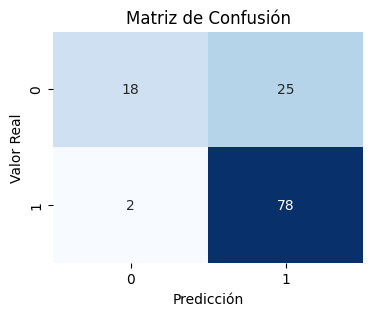

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que ya tienes best_model entrenado con los mejores hiperparámetros y X_test, y_test están definidos

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión usando Seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

Podemos apreciar que hay muchos falsos positivos, esto indica que hay un problema al momento de clasificar los datos que pertenecen a la categoría 0, o las personas a las que le niegan el prestamo. Inferimos que esto se debe al desbalanceo de clases que existe en los datos de entrenamiento, así que haremos un sobremuestreo y posteriormente volveremos a entrenar el modelo

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Realiza la verificación del balance actual
class_distribution_before = pd.Series(y).value_counts()
print("Distribución de clases antes del sobremuestreo:")
print(class_distribution_before)

# Aplica sobremuestreo para equilibrar las clases
oversample = RandomOverSampler(random_state=42)
X_over, y_over = oversample.fit_resample(X, y)

# Verifica la distribución de clases después del sobremuestreo
class_distribution_after = pd.Series(y_over).value_counts()
print("\nDistribución de clases después del sobremuestreo:")
print(class_distribution_after)

Distribución de clases antes del sobremuestreo:
1    422
0    192
Name: Loan_Status, dtype: int64

Distribución de clases después del sobremuestreo:
1    422
0    422
Name: Loan_Status, dtype: int64


In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

param_grid_over = {
    'n_estimators': [50, ], #Le quité los otros (100 y 150) pa que no se demore tanto :/, además de que los mejores resultados en el anterior eran con 50
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'subsample': [0.8, 0.9, 1.0]
}

# Inicializar el modelo Gradient Boosting Classifier
model_over = GradientBoostingClassifier()

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search_over = GridSearchCV(model_over, param_grid_over, cv=5, scoring='accuracy')
grid_search_over.fit(X_over_train, y_over_train)

# Obtener el mejor modelo y hacer predicciones en el conjunto de prueba
best_model_over = grid_search_over.best_estimator_
predictions_over = best_model_over.predict(X_over_test)

# Calcular la precisión del mejor modelo en el conjunto de prueba
accuracy = accuracy_score(y_over_test, predictions_over)
print("Mejor precisión del modelo en el conjunto de prueba: {:.2f}".format(accuracy))

Mejor precisión del modelo en el conjunto de prueba: 0.85


In [ ]:
# Calcular la precisión en los conjuntos de entrenamiento y prueba
train_accuracy_over = best_model_over.score(X_over_train, y_over_train)
test_accuracy_over = best_model_over.score(X_over_test, y_over_test)

# Imprimir las precisiones en dos líneas consecutivas
print("Accuracy en conjunto de entrenamiento:", train_accuracy_over)
print("Accuracy en conjunto de prueba      :", test_accuracy_over)

Accuracy en conjunto de entrenamiento: 0.9333333333333333
Accuracy en conjunto de prueba      : 0.8520710059171598


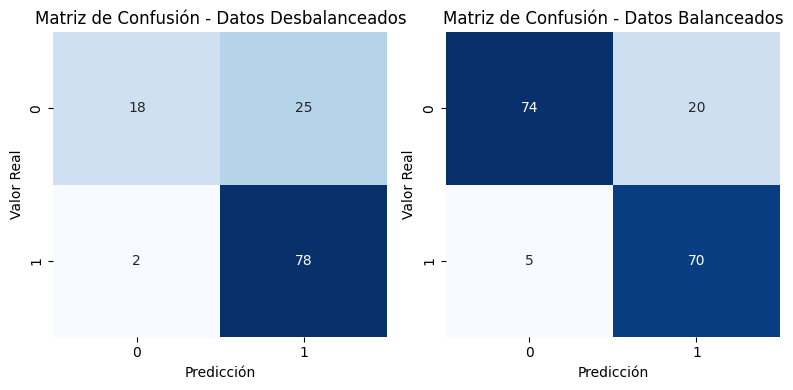

In [ ]:
# Obtiene las predicciones y las matrices de confusión
y_pred_normal = best_model.predict(X_test)
y_pred_over = best_model_over.predict(X_over_test)

conf_matrix_normal = confusion_matrix(y_test, y_pred_normal)
conf_matrix_over = confusion_matrix(y_over_test, y_pred_over)

# Grafica las matrices de confusión
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Datos Desbalanceados')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_over, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Datos Balanceados')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score

# Calcular F1-score, precisión y exhaustividad en los datos desbalanceados
f1_normal = f1_score(y_test, best_model.predict(X_test))
precision_normal = precision_score(y_test, best_model.predict(X_test))
recall_normal = recall_score(y_test, best_model.predict(X_test))
roc_auc_normal = roc_auc_score(y_test, best_model.predict(X_test))
average_precision_normal = average_precision_score(y_test, best_model.predict(X_test))

# Calcular las mismas métricas en los datos balanceados
f1_over = f1_score(y_over_test, best_model_over.predict(X_over_test))
precision_over = precision_score(y_over_test, best_model_over.predict(X_over_test))
recall_over = recall_score(y_over_test, best_model_over.predict(X_over_test))
roc_auc_over = roc_auc_score(y_over_test, best_model_over.predict(X_over_test))
average_precision_over = average_precision_score(y_over_test, best_model_over.predict(X_over_test))

# Imprimir métricas
print("Métricas en datos desbalanceados:")
print("F1-score:", f1_normal)
print("Precisión:", precision_normal)
print("Exhaustividad:", recall_normal)
print("ROC AUC:", roc_auc_normal)
print("Average Precision:", average_precision_normal)

print("\nMétricas en datos balanceados:")
print("F1-score:", f1_over)
print("Precisión:", precision_over)
print("Exhaustividad:", recall_over)
print("ROC AUC:", roc_auc_over)
print("Average Precision:", average_precision_over)

Métricas en datos desbalanceados:
F1-score: 0.8524590163934427
Precisión: 0.7572815533980582
Exhaustividad: 0.975
ROC AUC: 0.6968023255813953
Average Precision: 0.7546096771647328

Métricas en datos balanceados:
F1-score: 0.8484848484848485
Precisión: 0.7777777777777778
Exhaustividad: 0.9333333333333333
ROC AUC: 0.8602836879432625
Average Precision: 0.7555117247424941


In [ ]:
feature_importance_normal = best_model.feature_importances_
feature_importance_over = best_model_over.feature_importances_

# Imprimir la importancia de características
print("Importancia de características en datos desbalanceados:")
print(dict(zip(X.columns, feature_importance_normal)))

print("\nImportancia de características en datos balanceados:")
print(dict(zip(X.columns, feature_importance_over)))

Importancia de características en datos desbalanceados:
{'Gender': 0.010772499429866975, 'Married': 0.021968748379037572, 'Dependents': 0.021710649657660536, 'Education': 0.012647351311769268, 'Self_Employed': 0.005761504787885487, 'ApplicantIncome': 0.09176367103185519, 'CoapplicantIncome': 0.08462157824175415, 'LoanAmount': 0.142526014610178, 'Loan_Amount_Term': 0.05510110428795689, 'Credit_History': 0.4967021226147542, 'Property_Area': 0.05642475564728182}

Importancia de características en datos balanceados:
{'Gender': 0.012874637444885628, 'Married': 0.032017035065320436, 'Dependents': 0.030645641805770733, 'Education': 0.022067124039935798, 'Self_Employed': 0.007318975425254616, 'ApplicantIncome': 0.1631806198857434, 'CoapplicantIncome': 0.12828569703019965, 'LoanAmount': 0.147787042356521, 'Loan_Amount_Term': 0.0401968692129922, 'Credit_History': 0.35688980271806775, 'Property_Area': 0.05873655501530875}


###RNA

####Inicialización

In [ ]:
#Importación de librerías
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [ ]:
#Conectar Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importar la data

path = '/content/drive/MyDrive/Modelos II/Proyecto final/data/' #Change this path for your own path
data = pd.read_csv(path + 'data.csv')
data.head(5)

Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0       1        0           0          1              0           5849.0   
1       1        1           1          1              0           4583.0   
2       1        1           0          1              1           3000.0   
3       1        1           0          0              0           2583.0   
4       1        0           0          1              0           6000.0   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0  146.412162                 8               1   
1             1508.0  128.000000                 8               1   
2                0.0   66.000000                 8               1   
3             2358.0  120.000000                 8               1   
4                0.0  141.000000                 8               1   

   Property_Area  Loan_Status  
0              2            1  
1              0            0  
2              2            1  
3              2            1  
4              2            1

####Búsqueda de Mejores parámetros

In [ ]:
from sklearn.model_selection import train_test_split

#Definición de los datos para entrenamiento y para testeo
X = data.iloc[:, :11]
y = data.iloc[:, 11]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = True, stratify= y, random_state=11)

In [ ]:
#Modelo al que se quiere optimizar los hiperparámetros
default_model = MLPClassifier(random_state = 11, max_iter = 1000)

In [ ]:
#GridSearch para un RNA de una capa
one_layer_param_grid = {
    'hidden_layer_sizes': [(i,) for i in range(2, 17, 2)],
    'activation': ['relu', 'logistic', 'tanh', 'identity'],
}

one_layer_grid_search = GridSearchCV(estimator=default_model, param_grid=one_layer_param_grid ,cv = 5,scoring='accuracy')
one_layer_grid_result = one_layer_grid_search.fit(X_train, y_train)

print("Best parameters found: ", one_layer_grid_search.best_params_)
print("Best accuracy found: {:.2f}".format(one_layer_grid_search.best_score_ * 100))

Best parameters found:  {'activation': 'tanh', 'hidden_layer_sizes': (14,)}
Best accuracy found: 69.00


In [ ]:
#GridSearch para un RNA de dos capas
two_layer_param_grid = {
    'hidden_layer_sizes': [(i, i) for i in range(2, 17, 2)],
    'activation': ['relu', 'logistic', 'tanh', 'identity'],
}

two_layer_grid_search = GridSearchCV(estimator=default_model, param_grid=two_layer_param_grid, cv = 5, scoring='accuracy')
two_layer_grid_result = two_layer_grid_search.fit(X_train, y_train)

print("Best parameters found: ", two_layer_grid_search.best_params_)
print("Best accuracy found: {:.2f}".format(two_layer_grid_search.best_score_ * 100))

Best parameters found:  {'activation': 'identity', 'hidden_layer_sizes': (14, 14)}
Best accuracy found: 69.00


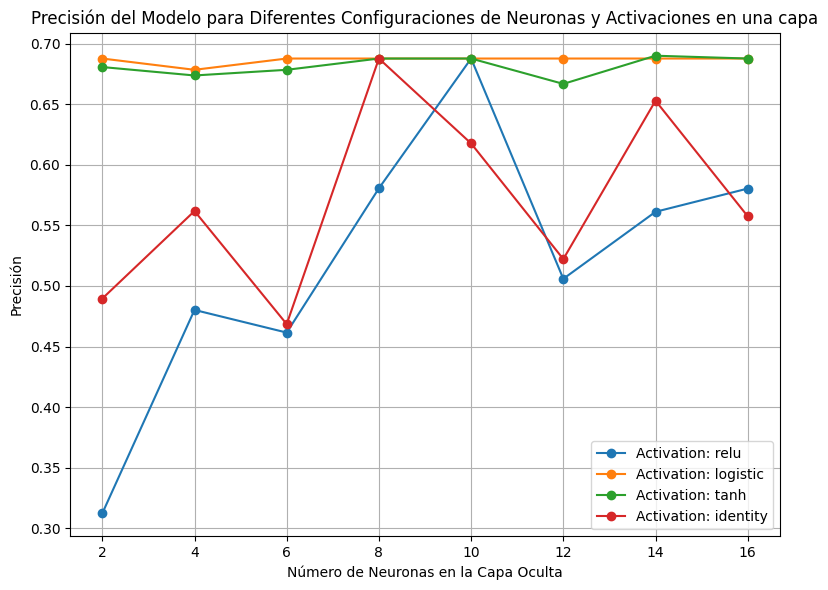

In [ ]:
# Análisis para la red neuronal con solo una capa
neurons = [param['hidden_layer_sizes'] for param in one_layer_grid_result.cv_results_['params']]
activations = [param['activation'] for param in one_layer_grid_result.cv_results_['params']]
accuracy = one_layer_grid_result.cv_results_['mean_test_score']

activation_data = {}
for i, activation in enumerate(activations):
    if activation not in activation_data:
        activation_data[activation] = {'neurons': [], 'accuracy': []}
    activation_data[activation]['neurons'].append(neurons[i][0])
    activation_data[activation]['accuracy'].append(accuracy[i])

plt.figure(figsize=(8, 6))
for activation, data in activation_data.items():
    plt.plot(data['neurons'], data['accuracy'], marker='o', label=f'Activation: {activation}')

plt.xlabel('Número de Neuronas en la Capa Oculta')
plt.ylabel('Precisión')
plt.title('Precisión del Modelo para Diferentes Configuraciones de Neuronas y Activaciones en una capa')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Top 15 better configs
results = pd.DataFrame(one_layer_grid_result.cv_results_)
top_configs = results.sort_values(by='mean_test_score', ascending=False).head(15)

df_top = pd.DataFrame()
df_top['Activation'] = top_configs.param_activation
df_top['Hidden layer sizes'] =  top_configs.param_hidden_layer_sizes
df_top['Rank'] = top_configs.rank_test_score
df_top['Accuracy'] =  top_configs.mean_test_score

df_top

Activation Hidden layer sizes  Rank  Accuracy
22       tanh              (14,)     1  0.689986
12   logistic              (10,)     2  0.687661
10   logistic               (6,)     2  0.687661
20       tanh              (10,)     2  0.687661
19       tanh               (8,)     2  0.687661
27   identity               (8,)     2  0.687661
15   logistic              (16,)     2  0.687661
14   logistic              (14,)     2  0.687661
13   logistic              (12,)     2  0.687661
11   logistic               (8,)     2  0.687661
23       tanh              (16,)     2  0.687661
8    logistic               (2,)     2  0.687661
4        relu              (10,)     2  0.687661
16       tanh               (2,)    14  0.680629
9    logistic               (4,)    15  0.678358

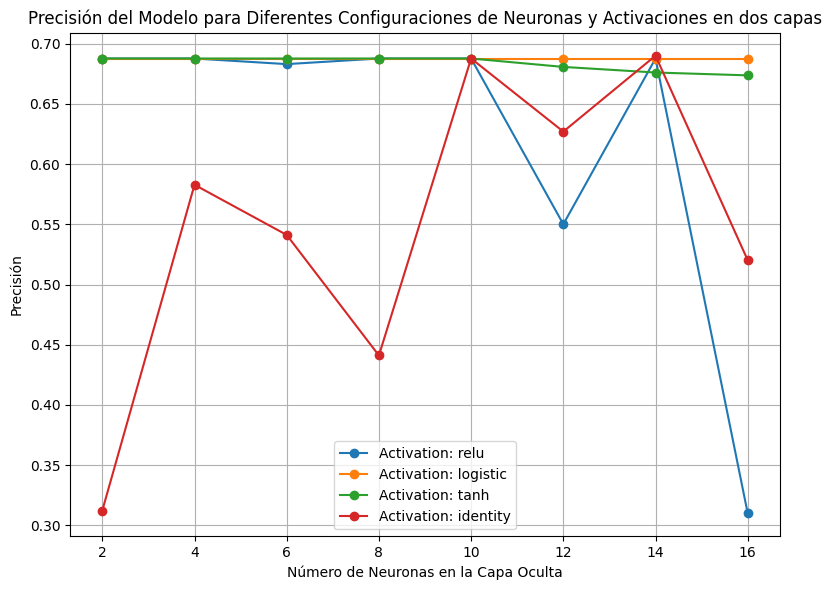

In [ ]:
# Análisis para la red neuronal con dos capas
neurons = [param['hidden_layer_sizes'] for param in two_layer_grid_result.cv_results_['params']]
activations = [param['activation'] for param in two_layer_grid_result.cv_results_['params']]
accuracy = two_layer_grid_result.cv_results_['mean_test_score']

activation_data = {}
for i, activation in enumerate(activations):
    if activation not in activation_data:
        activation_data[activation] = {'neurons': [], 'accuracy': []}
    activation_data[activation]['neurons'].append(neurons[i][0])
    activation_data[activation]['accuracy'].append(accuracy[i])

plt.figure(figsize=(8, 6))
for activation, data in activation_data.items():
    plt.plot(data['neurons'], data['accuracy'], marker='o', label=f'Activation: {activation}')

plt.xlabel('Número de Neuronas en la Capa Oculta')
plt.ylabel('Precisión')
plt.title('Precisión del Modelo para Diferentes Configuraciones de Neuronas y Activaciones en dos capas')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Análisis de capas y número de neuronas

Los resultados vistos en las 2 gráficas nos sugieren que la diferencia en el la precisión entre una red de 1 capa y de 2 capas es mínima, por lo tanto podemos ir por el modelo que usa una única capa debido a que es más simple y requiere menos poder computacional.

Los hiperparametros de `activation` que nos ofrecen mayor precisión son el de `tanh` y `logistic`, sus valores máximos son muy parecidos, poseen diferencias del orden de 1*E-3,porlo cual no es una diferencia alarmante. La configuración de hiperparámetros más óptima es aquella con `activation = tanh, neurons = 12`, ofreciendo una precisión de 70.166895, pero con la configuración  `activation = logistic, neurons = 2` se consigue una precisión de 70.164159, un valor muy al anterior y usando solo 2 neuronas.

Los expuesto anteriormente sugiere que el mejor modelo, por ahora, es el el que está configurado con `activation = logistic, neurons = 2`


####Cálculo de la Matriz de Confusión

Para este procesos se crea el modelo basado en los mejores parámetros obtenidos en el paso anterior, luego este modelo es puesto bajo entrenamiento bajo el marco de una validación cruzada usando el método de StratifiedKFold usando 5 splits

In [ ]:
model = MLPClassifier(activation = 'logistic' , hidden_layer_sizes = (2,), random_state = 11, max_iter=1000).fit(X_train, y_train)
model

MLPClassifier(activation='logistic', hidden_layer_sizes=(2,), max_iter=1000,
              random_state=11)

In [ ]:
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print('Accuracy en el conjunto de datos de entrenamiento:' + str(train_accuracy))
print('Accuracy en el conjunto de datos de testeo:' + str(test_accuracy))

Accuracy en el conjunto de datos de entrenamiento:0.6876456876456877
Accuracy en el conjunto de datos de testeo:0.6864864864864865


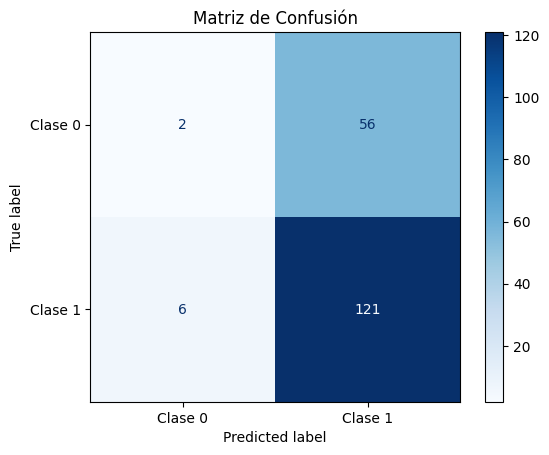

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

stratified_kfold = StratifiedKFold(n_splits=5, random_state=11, shuffle=True)

# Realiza la validación cruzada estratificada y obtención de predicciones
y_pred = cross_val_predict(model, X_test, y_test, cv=stratified_kfold)

# Visualiza la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Clase 0", "Clase 1"])
disp.plot(cmap=plt.cm.Blues, values_format=".0f")
plt.title('Matriz de Confusión')
plt.show()

Esta matriz es leída de la siguiente manera:

| Verdaderos Negativos (TN) | Falsos Positivos (FP) |
| ------------------------- | ---------------------- |
| Falsos Negativos (FN)     | Verdaderos Positivos (TP) |



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix

# Calcular métricas usando funciones de Scikit-Learn
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Calcular especificidad y tasa de falsos positivos manualmente a partir de la matriz de confusión
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
fpr = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Calcular precisión balanceada (BACC)
bacc = (recall + specificity) / 2

# Imprimir las métricas
print("Precisión: {:.2f}".format(precision))
print("Exactitud: {:.2f}".format(accuracy))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))
print("Coeficiente de Correlación de Matthews (MCC): {:.2f}".format(mcc))
print("Especificidad: {:.2f}".format(specificity))
print("Tasa de Falsos Positivos (FPR): {:.2f}".format(fpr))
print("Precisión Balanceada (BACC): {:.2f}".format(bacc))

Precisión: 0.68
Exactitud: 0.66
Recall: 0.95
F1-score: 0.80
Coeficiente de Correlación de Matthews (MCC): -0.03
Especificidad: 0.03
Tasa de Falsos Positivos (FPR): 0.97
Precisión Balanceada (BACC): 0.49


####Implementación del modelo con algoritmos de balanceo de clases

In [ ]:
from sklearn.model_selection import KFold

def calc_metrics(x, y, X_test, y_test, description):

  model = MLPClassifier(activation = 'logistic' , hidden_layer_sizes = (2,), random_state = 11, max_iter=1000).fit(x, y)

  print('\n' + description + '\n')
  print('Accuracy en el conjunto de datos de entrenamiento:' +str(model.score(x, y)))
  print('Accuracy en el conjunto de datos de testeo:' +str(model.score(X_test, y_test)))

  y_pred = model.predict(X_test)
  kfold = KFold(n_splits=10, random_state=11, shuffle=True)
  y_pred = cross_val_predict(model, X_test, y_test, cv=kfold)
  conf_matrix = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Clase 0", "Clase 1"])
  disp.plot(cmap=plt.cm.Blues, values_format=".0f")
  plt.title('Matriz de Confusión')
  plt.show()

  precision = precision_score(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  mcc = matthews_corrcoef(y_test, y_pred)
  specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
  fpr = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])
  bacc = (recall + specificity) / 2
  # Imprimir las métricas
  print("Precisión: {:.2f}".format(precision))
  print("Exactitud: {:.2f}".format(accuracy))
  print("Recall: {:.2f}".format(recall))
  print("F1-score: {:.2f}".format(f1))
  print("Coeficiente de Correlación de Matthews (MCC): {:.2f}".format(mcc))
  print("Especificidad: {:.2f}".format(specificity))
  print("Tasa de Falsos Positivos (FPR): {:.2f}".format(fpr))
  print("Precisión Balanceada (BACC): {:.2f}".format(bacc))


In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter


ORIGINAL

Accuracy en el conjunto de datos de entrenamiento:0.6876456876456877
Accuracy en el conjunto de datos de testeo:0.6864864864864865


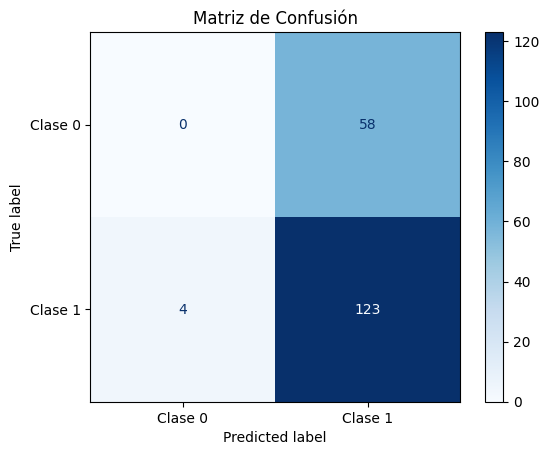

Precisión: 0.68
Exactitud: 0.66
Recall: 0.97
F1-score: 0.80
Coeficiente de Correlación de Matthews (MCC): -0.10
Especificidad: 0.00
Tasa de Falsos Positivos (FPR): 1.00
Precisión Balanceada (BACC): 0.48


In [ ]:
calc_metrics(X_train, y_train, X_test, y_test, 'ORIGINAL')

Datos antes del sobremuestreo: 
1    295
0    134
Name: Loan_Status, dtype: int64
Datos antes del sobremuestreo: 
1    295
0    295
Name: Loan_Status, dtype: int64

SMOTE

Accuracy en el conjunto de datos de entrenamiento:0.5
Accuracy en el conjunto de datos de testeo:0.31351351351351353


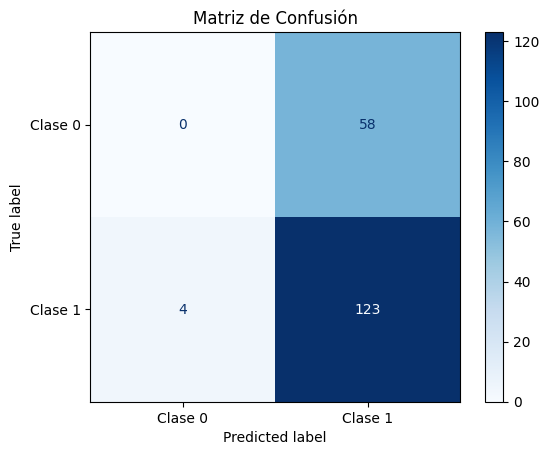

Precisión: 0.68
Exactitud: 0.66
Recall: 0.97
F1-score: 0.80
Coeficiente de Correlación de Matthews (MCC): -0.10
Especificidad: 0.00
Tasa de Falsos Positivos (FPR): 1.00
Precisión Balanceada (BACC): 0.48


In [ ]:
class_distribution_before = pd.Series(y_train).value_counts()
print('Datos antes del sobremuestreo: ')
print(class_distribution_before)

X_smote, y_smote = SMOTE().fit_resample(X_train, y_train)

class_distribution_after = pd.Series(y_smote).value_counts()
print('Datos antes del sobremuestreo: ')
print(class_distribution_after)

calc_metrics(X_smote, y_smote, X_test, y_test, 'SMOTE')

Datos antes del sobremuestreo: 
1    295
0    134
Name: Loan_Status, dtype: int64
Datos antes del sobremuestreo: 
1    295
0    281
Name: Loan_Status, dtype: int64

ADASYN

Accuracy en el conjunto de datos de entrenamiento:0.5399305555555556
Accuracy en el conjunto de datos de testeo:0.654054054054054


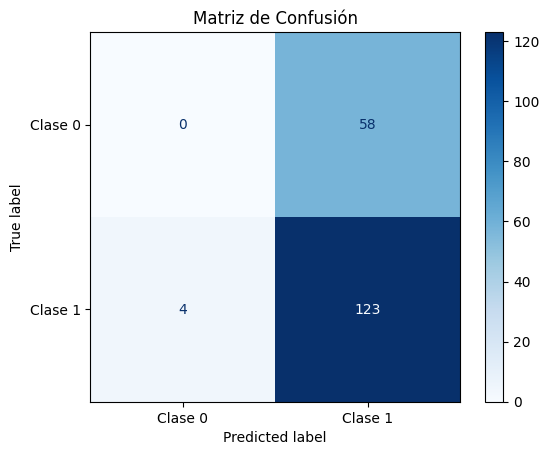

Precisión: 0.68
Exactitud: 0.66
Recall: 0.97
F1-score: 0.80
Coeficiente de Correlación de Matthews (MCC): -0.10
Especificidad: 0.00
Tasa de Falsos Positivos (FPR): 1.00
Precisión Balanceada (BACC): 0.48


In [ ]:
class_distribution_before = pd.Series(y_train).value_counts()
print('Datos antes del sobremuestreo: ')
print(class_distribution_before)

X_adasyn, y_adasyn = ADASYN().fit_resample(X_train, y_train)

class_distribution_after = pd.Series(y_adasyn).value_counts()
print('Datos antes del sobremuestreo: ')
print(class_distribution_after)

calc_metrics(X_adasyn, y_adasyn, X_test, y_test, 'ADASYN')

Datos antes del sobremuestreo: 
1    295
0    134
Name: Loan_Status, dtype: int64
Datos antes del sobremuestreo: 
1    295
0    295
Name: Loan_Status, dtype: int64

Random OverSampling

Accuracy en el conjunto de datos de entrenamiento:0.5
Accuracy en el conjunto de datos de testeo:0.31351351351351353


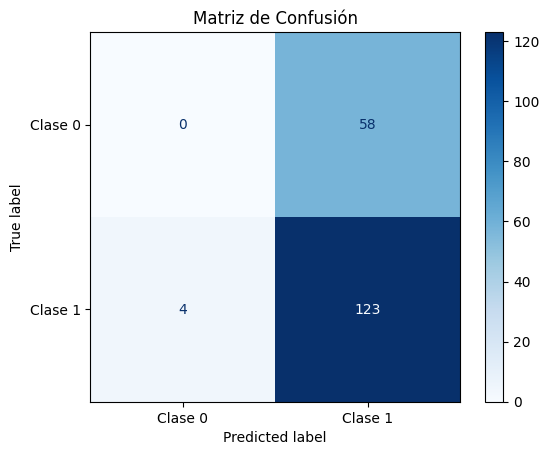

Precisión: 0.68
Exactitud: 0.66
Recall: 0.97
F1-score: 0.80
Coeficiente de Correlación de Matthews (MCC): -0.10
Especificidad: 0.00
Tasa de Falsos Positivos (FPR): 1.00
Precisión Balanceada (BACC): 0.48


In [ ]:
from imblearn.over_sampling import RandomOverSampler

class_distribution_before = pd.Series(y_train).value_counts()
print('Datos antes del sobremuestreo: ')
print(class_distribution_before)

X_ros, y_ros = RandomOverSampler().fit_resample(X_train, y_train)

class_distribution_after = pd.Series(y_ros).value_counts()
print('Datos antes del sobremuestreo: ')
print(class_distribution_after)

calc_metrics(X_ros, y_ros, X_test, y_test, 'Random OverSampling')

###Support Vector Machine

In [ ]:
!pip install scikit-optimize
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import TomekLinks
from sklearn import datasets

In [ ]:
# Importación de datos de entrenamiento limpios (De momento haré la importación de los datos subiendo el archivo)
data_train_clean = pd.read_csv('clean_data_train.csv')

X = data_train_clean.iloc[:, :-1]
y = data_train_clean.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [ ]:
# Rango de valores para los hiperparámetros a ajustar
param_grid = {
    'C': [0.1, 1, 5],
    'kernel': ['linear', 'rbf'],
}

In [ ]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 5], 'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [ ]:
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_

accuracy = best_model.score(X_test, y_test)

print("Mejores hiperparámetros encontrados:", best_params)
print("Precisión en datos de prueba:", accuracy)

Mejores hiperparámetros encontrados: {'C': 1, 'kernel': 'linear'}
Precisión en datos de prueba: 0.7642276422764228


In [ ]:
!pip install imbalanced-learn

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import TomekLinks  # Importa el módulo para Tomek Links
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Aplica Tomek Links para eliminar ejemplos de clases opuestas en los datos de entrenamiento
tl = TomekLinks()
X_resampled, y_resampled = tl.fit_resample(X_train, y_train)

# Crea un clasificador SVM con los mejores hiperparámetros
svm = SVC(C=1, kernel='linear')

# Entrena el modelo SVM en los datos de entrenamiento equilibrados
svm.fit(X_resampled, y_resampled)

# Realiza predicciones en los datos de prueba
y_pred = svm.predict(X_test)

# Evalúa el modelo en los datos de prueba
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7723577235772358


Matriz de Confusión:
[[11 25]
 [ 3 84]]


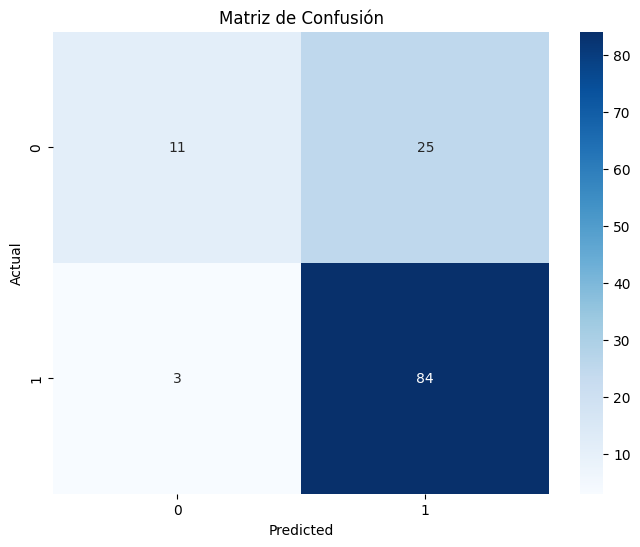

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.79      0.31      0.44        36
           1       0.77      0.97      0.86        87

    accuracy                           0.77       123
   macro avg       0.78      0.64      0.65       123
weighted avg       0.78      0.77      0.74       123



In [ ]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

print("Matriz de Confusión:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión")
plt.show()

report = classification_report(y_test, y_pred)
print("Reporte de Clasificación:")
print(report)

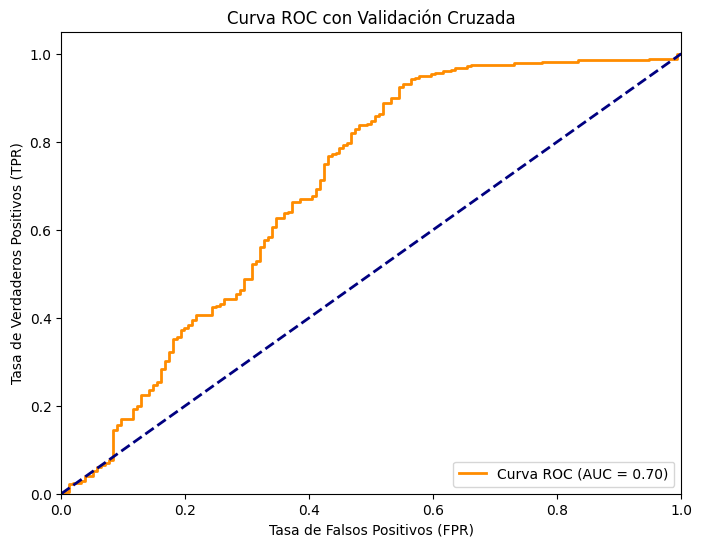

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Calcular la curva ROC
y_scores = cross_val_predict(svm, X_resampled, y_resampled, cv=5, method='decision_function')

fpr, tpr, thresholds = roc_curve(y_resampled, y_scores)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC con Validación Cruzada')
plt.legend(loc='lower right')
plt.show()
